# Continuous Control with DDPG

---
### 1. Train the agent

Run the next code cell to train the agent. 

In [ ]:
from collections import deque
from unityagents import UnityEnvironment
import numpy as np
from ddpg_agent import Agent
import torch
import time

agent = Agent(state_size=33, action_size=4, random_seed=0)
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')
brain_name = env.brain_names[0]                    # get the default brain
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
num_agents = len(env_info.agents)

def ddpg(n_episodes=800, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores_global = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations              # get the current state for each agent
        scores = np.zeros(num_agents)                     # initialize the score (for each agent)
        agent.reset()
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]        # send all actions to the environment
            next_states = env_info.vector_observations     # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done
            scores += env_info.rewards                         # update the score (for each agent)
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)
            if np.any(dones):
                print(t)
                break 
            states = next_states
            
        agent.learn2()
        score = np.mean(scores)
        scores_deque.append(score)
        scores_global.append(score)
        print('\rEpisode {}, Mean last 100: {:.2f}, Mean current: {:.2f}, Max: {:.2f}, Min: {:.2f}'\
          .format(i_episode, np.mean(scores_deque), score, np.max(scores), np.min(scores), end="\n"))
        if i_episode % 10 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')            
            np.save('scores_global_reacher.npy', scores_global)
    return scores_global

scores = ddpg()


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 1, Mean last 100: 0.01, Mean current: 0.01, Max: 0.16, Min: 0.00
Episode 2, Mean last 100: 0.32, Mean current: 0.63, Max: 1.47, Min: 0.10
Episode 3, Mean last 100: 0.29, Mean current: 0.24, Max: 0.68, Min: 0.00
Episode 4, Mean last 100: 0.22, Mean current: 0.01, Max: 0.12, Min: 0.00
Episode 5, Mean last 100: 0.31, Mean current: 0.67, Max: 2.12, Min: 0.00
Episode 6, Mean last 100: 0.32, Mean current: 0.34, Max: 1.39, Min: 0.00
Episode 7, Mean last 100: 0.34, Mean current: 0.46, Max: 1.48, Min: 0.06
Episode 8, Mean last 100: 0.36, Mean current: 0.55, Max: 1.77, Min: 0.00
Episode 9, Mean last 100: 0.41, Mean current: 0.74, Max: 1.93, Min: 0.12
Episode 10, Mean last 100: 0.44, Mean current: 0.79, Max: 1.61, Min: 0.19
Episode 11, Mean last 100: 0.49, Mean current: 0.97, Max: 1.98, Min: 0.31
Episode 12, Mean last 100: 0.50, Mean current: 0.62, Max: 1.40, Min: 0.00
Episode 13, Mean last 100: 0.53, Mean current: 0.82, Max: 1.60, Min: 0.09
Episode 14, Mean last 100: 0.58, Mean current: 

Episode 112, Mean last 100: 2.07, Mean current: 2.69, Max: 6.19, Min: 0.68
Episode 113, Mean last 100: 2.09, Mean current: 3.19, Max: 5.93, Min: 0.48
Episode 114, Mean last 100: 2.10, Mean current: 2.31, Max: 4.44, Min: 1.08
Episode 115, Mean last 100: 2.11, Mean current: 1.97, Max: 4.82, Min: 0.27
Episode 116, Mean last 100: 2.13, Mean current: 2.78, Max: 8.58, Min: 0.74
Episode 117, Mean last 100: 2.15, Mean current: 2.64, Max: 6.07, Min: 0.71
Episode 118, Mean last 100: 2.18, Mean current: 3.36, Max: 5.44, Min: 1.34
Episode 119, Mean last 100: 2.20, Mean current: 3.01, Max: 7.80, Min: 0.78
Episode 120, Mean last 100: 2.22, Mean current: 2.88, Max: 7.54, Min: 0.48
Episode 121, Mean last 100: 2.25, Mean current: 3.71, Max: 7.60, Min: 1.04
Episode 122, Mean last 100: 2.28, Mean current: 4.20, Max: 7.04, Min: 1.17
Episode 123, Mean last 100: 2.30, Mean current: 3.53, Max: 7.34, Min: 1.34
Episode 124, Mean last 100: 2.34, Mean current: 4.63, Max: 8.99, Min: 1.86
Episode 125, Mean last 10

Episode 220, Mean last 100: 8.02, Mean current: 17.21, Max: 28.22, Min: 8.33
Episode 221, Mean last 100: 8.12, Mean current: 13.89, Max: 22.99, Min: 5.12
Episode 222, Mean last 100: 8.23, Mean current: 15.19, Max: 26.63, Min: 4.54
Episode 223, Mean last 100: 8.36, Mean current: 16.60, Max: 30.45, Min: 7.28
Episode 224, Mean last 100: 8.44, Mean current: 12.65, Max: 19.62, Min: 5.87
Episode 225, Mean last 100: 8.58, Mean current: 18.77, Max: 25.77, Min: 5.12
Episode 226, Mean last 100: 8.71, Mean current: 16.61, Max: 26.96, Min: 3.90
Episode 227, Mean last 100: 8.80, Mean current: 12.97, Max: 26.91, Min: 6.98
Episode 228, Mean last 100: 8.91, Mean current: 15.22, Max: 25.62, Min: 4.87
Episode 229, Mean last 100: 9.03, Mean current: 15.15, Max: 24.50, Min: 5.28
Episode 230, Mean last 100: 9.14, Mean current: 15.11, Max: 24.28, Min: 6.12
Episode 231, Mean last 100: 9.24, Mean current: 12.86, Max: 30.12, Min: 4.85
Episode 232, Mean last 100: 9.34, Mean current: 14.92, Max: 24.11, Min: 7.01

Episode 325, Mean last 100: 20.94, Mean current: 26.89, Max: 39.01, Min: 15.55
Episode 326, Mean last 100: 21.05, Mean current: 27.97, Max: 39.43, Min: 15.46
Episode 327, Mean last 100: 21.19, Mean current: 27.04, Max: 36.11, Min: 14.65
Episode 328, Mean last 100: 21.32, Mean current: 27.79, Max: 34.90, Min: 18.24
Episode 329, Mean last 100: 21.45, Mean current: 28.74, Max: 35.56, Min: 18.23
Episode 330, Mean last 100: 21.59, Mean current: 29.25, Max: 37.18, Min: 10.27
Episode 331, Mean last 100: 21.78, Mean current: 31.24, Max: 37.91, Min: 15.85
Episode 332, Mean last 100: 21.92, Mean current: 29.30, Max: 36.58, Min: 7.72
Episode 333, Mean last 100: 22.03, Mean current: 24.65, Max: 33.76, Min: 15.59
Episode 334, Mean last 100: 22.19, Mean current: 30.89, Max: 36.60, Min: 15.82
Episode 335, Mean last 100: 22.37, Mean current: 31.94, Max: 38.18, Min: 19.63
Episode 336, Mean last 100: 22.50, Mean current: 32.22, Max: 39.30, Min: 19.97
Episode 337, Mean last 100: 22.69, Mean current: 33.1

Episode 430, Mean last 100: 29.39, Mean current: 35.40, Max: 39.34, Min: 16.03
Episode 431, Mean last 100: 29.42, Mean current: 33.96, Max: 38.91, Min: 22.19
Episode 432, Mean last 100: 29.49, Mean current: 36.40, Max: 38.63, Min: 28.94
Episode 433, Mean last 100: 29.61, Mean current: 36.82, Max: 39.30, Min: 29.46
Episode 434, Mean last 100: 29.66, Mean current: 35.91, Max: 39.08, Min: 28.99
Episode 435, Mean last 100: 29.70, Mean current: 35.56, Max: 38.99, Min: 15.95
Episode 436, Mean last 100: 29.74, Mean current: 36.26, Max: 39.03, Min: 24.86
Episode 437, Mean last 100: 29.76, Mean current: 35.32, Max: 38.48, Min: 22.48
Episode 438, Mean last 100: 29.83, Mean current: 32.74, Max: 38.14, Min: 16.77
Episode 439, Mean last 100: 29.86, Mean current: 34.15, Max: 37.78, Min: 26.65
Episode 440, Mean last 100: 29.91, Mean current: 33.01, Max: 39.05, Min: 22.13
Episode 441, Mean last 100: 29.98, Mean current: 33.82, Max: 38.71, Min: 21.51
Episode 442, Mean last 100: 30.03, Mean current: 35.

Episode 534, Mean last 100: 33.60, Mean current: 31.33, Max: 38.26, Min: 12.92
Episode 535, Mean last 100: 33.56, Mean current: 31.19, Max: 37.79, Min: 20.93
Episode 536, Mean last 100: 33.52, Mean current: 32.25, Max: 37.98, Min: 23.42
Episode 537, Mean last 100: 33.52, Mean current: 35.29, Max: 39.24, Min: 28.44
Episode 538, Mean last 100: 33.49, Mean current: 29.95, Max: 36.72, Min: 18.22
Episode 539, Mean last 100: 33.46, Mean current: 31.59, Max: 37.44, Min: 20.47
Episode 540, Mean last 100: 33.46, Mean current: 32.73, Max: 39.15, Min: 15.25
Episode 541, Mean last 100: 33.48, Mean current: 35.96, Max: 38.58, Min: 28.98
Episode 542, Mean last 100: 33.46, Mean current: 33.67, Max: 38.43, Min: 24.38
Episode 543, Mean last 100: 33.41, Mean current: 30.16, Max: 39.20, Min: 17.50
Episode 544, Mean last 100: 33.39, Mean current: 30.61, Max: 37.30, Min: 22.78
Episode 545, Mean last 100: 33.38, Mean current: 32.33, Max: 38.44, Min: 21.46
Episode 546, Mean last 100: 33.41, Mean current: 32.

### 2. Watch a trained agent


In [ ]:
from unityagents import UnityEnvironment
import numpy as np
from ddpg_agent import Agent
import torch

agent = Agent(state_size=33, action_size=4, random_seed=0)
#load weights
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location=lambda storage, loc: storage))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth', map_location=lambda storage, loc: storage))


env = UnityEnvironment(file_name='Reacher_V01')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
state = env_info.vector_observations[0]                  # get the current state (for each agent)
scores = 0;

while True:
    #actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    action = agent.act(state, False) #add noise false
    env_info = env.step(action)[brain_name]        # send the action to the environment
    state = env_info.vector_observations[0]   # get the next state
    done  = env_info.local_done[0]
    scores += env_info.rewards[0]                         # update the score (for each agent)
    if done:                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
env.close()

### 3. Plot results

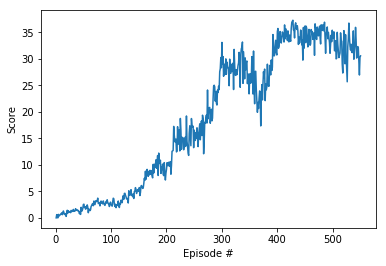

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
scores = np.load('scores_global_reacher.npy')
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

fig.tight_layout()
fig.savefig('output.png', dpi=300)